# Unsupervised learning

We will look at an example covered in "Hands-on Unsupervised Learning Using Python" by Ankur A. Patel. The accompanying material for the book can be found [here](https://github.com/aapatel09/handson-unsupervised-learning).

In [ ]:
# Download the dataset from s3
!pip install awscli
!aws s3 cp s3://handson-unsupervised-learning/datasets/credit_card_data credit_card_data --recursive --no-sign-request

In [1]:
import os, time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle

## Preparing the data

We will use a dataset containing credit card transactions from the book's accompanying material.

In [ ]:
data = pd.read_csv('./credit_card_data/credit_card.csv')
data.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [ ]:
# Separate the samples and labels.
# We choose the class column as our labels which classifies transactions
# as valid (0) or fraudulent (1).

samples = data.copy().drop(['Class','Time'],axis=1)
labels = data['Class'].copy()

# Split the data into train and test sets

train_samples, test_samples, train_labels, test_labels = train_test_split(
    samples, labels, test_size = 0.33, random_state=2022, stratify = labels
)

# Print out the shape of the train and test data

print('train samples: {}'.format(train_samples.shape))
print('(valid, fraud) = ({},{})'.format(
    (train_labels==0).sum(),(train_labels==1).sum()
))

print('test samples: {}'.format(test_samples.shape))
print('(valid, fraud) = ({},{})'.format(
    (test_labels==0).sum(),(test_labels==1).sum()
))

train samples: (190820, 29)
(valid, fraud) = (190490,330)
test samples: (93987, 29)
(valid, fraud) = (93825,162)


In [ ]:
t_means = samples.mean()
t_stds = samples.std()

In [ ]:
# Normalize the data

train_samples = (train_samples-t_means)/t_stds
test_samples = (test_samples-t_means)/t_stds

In [ ]:
# Oversample the fraudulent transactions

osp = 64
osr = 0.2

train_os_samples = train_samples.copy()
train_os_labels = train_labels.copy()

train_os_samples = train_os_samples.append(
    [train_os_samples[train_os_labels==1].sample(frac=0.2)]*osp,
    ignore_index = False
)

train_os_labels = train_os_labels.append(
    [train_os_labels[train_os_labels==1].sample(frac=0.2)]*osp,
    ignore_index = False
)

In [ ]:
train_os_samples.shape

(195044, 29)

In [ ]:
train_os_samples, train_os_labels = shuffle(train_os_samples, train_os_labels)

## Baseline model

In [ ]:
baseline_model = keras.Sequential([
    layers.Input(shape=(29,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
])

metric = ['binary_accuracy',
           keras.metrics.FalseNegatives(name='fn'),
           keras.metrics.FalsePositives(name='fp'),]
baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=metric)

In [ ]:
baseline_model.fit(train_os_samples, train_os_labels,
                   batch_size = 64, epochs=2,
                   validation_split=0.2)

Epoch 1/2
2439/2439 [==============================] - 6s 2ms/step - loss: 0.0053 - binary_accuracy: 0.9992 - fn: 61.0000 - fp: 62.0000 - val_loss: 0.0037 - val_binary_accuracy: 0.9995 - val_fn: 9.0000 - val_fp: 10.0000
Epoch 2/2
2439/2439 [==============================] - 6s 2ms/step - loss: 0.0048 - binary_accuracy: 0.9993 - fn: 54.0000 - fp: 63.0000 - val_loss: 0.0032 - val_binary_accuracy: 0.9994 - val_fn: 6.0000 - val_fp: 17.0000


In [ ]:
baseline_eval = baseline_model.evaluate(test_samples, test_labels)

2938/2938 [==============================] - 5s 2ms/step - loss: 0.0045 - binary_accuracy: 0.9993 - fn: 31.0000 - fp: 39.0000


In [ ]:
baseline_model.evaluate(test_samples[test_labels==1], test_labels[test_labels==1])

6/6 [==============================] - 0s 3ms/step - loss: 1.5529 - binary_accuracy: 0.8086 - fn: 31.0000 - fp: 0.0000e+00


[1.5529146194458008, 0.8086419701576233, 31.0, 0.0]

In [ ]:
baseline_fn = int(baseline_eval[2])
baseline_fp = int(baseline_eval[3])
baseline_tn = (test_labels==0).sum()
baseline_tp = (test_labels==1).sum()

baseline_cm = np.array([[baseline_tp - baseline_fn, baseline_fn], 
                        [baseline_fp, baseline_tn - baseline_fp]])

baseline_cm

array([[  131,    31],
       [   39, 93786]])

In [ ]:
# Accuracy of a constant model which classifies all transactions as valid

1-162/93987

0.9982763573685722

## Unsupervised model

The key idea behind unsupervised learning for fraud/anomaly detection is to first train a generative model. Since the data is so unbalanced, the generative model will mostly learn to generate valid transactions. Fraudulent/anomalous transaction will thus be generated poorly marking them as fradulent.

In [ ]:
model_fd = keras.Sequential([
    layers.Input(shape=(29,)),
    layers.Dense(128, activity_regularizer=keras.regularizers.l1(10e-5)),
    layers.LeakyReLU(alpha=0.2),
    layers.Dropout(0.2),
    layers.Dense(32),
    layers.LeakyReLU(alpha=0.2),
    layers.Dropout(0.2),
    layers.Dense(128, activity_regularizer=keras.regularizers.l1(10e-5)),
    layers.LeakyReLU(alpha=0.2),
    layers.Dropout(0.2),
    layers.Dense(29)
])

model_fd.compile(optimizer='adam',
                 loss='mse',
                 metrics='accuracy')

In [ ]:
model_fd.fit(train_os_samples, train_os_samples,
             batch_size = 64, epochs = 32,
             validation_split=0.2)

In [ ]:
# Calculate reconstruction error

def anomaly_scores(sample, reconstruction):
    loss = np.sum((np.array(sample) - 
                   np.array(reconstruction))**2, axis=1)
    loss = pd.Series(data=loss,index=sample.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [ ]:
test_scores = anomaly_scores(test_samples, model_fd.predict(test_samples))

In [ ]:
threshold = 0.03
tn = (test_labels==0).sum()
tp = (test_labels==1).sum()
fn = (test_scores[test_labels==1]<=threshold).sum()
fp = (test_scores[test_labels==0]>threshold).sum()
cm = np.array([[tp - fn, fn], [fp, tn - fp]])

cm

array([[   29,   133],
       [  197, 93628]])

In [ ]:
# Accuracy

(tp + tn - fp - fn)/(tp + tn)

0.9964888761211657

## Using GANs

### GAN model class

In [ ]:
# GAN model class

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        # The model simultaneously optimizes the generator and the discriminator.
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_samples):
        batch_size = tf.shape(real_samples)[0]
        # Generate random latent vectors used by the generator.
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        # Generator feedforward
        generated_samples = self.generator(random_latent_vectors)
        # Mix the real and fake samples.
        combined_samples = tf.concat([generated_samples, 
                                      tf.cast(real_samples, tf.float32)], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        # Introduce randomness which helps with training
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            # Discriminator feedforward
            predictions = self.discriminator(combined_samples)
            # Compute loss function with true labels.
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        # Update discriminator weights.
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        
        # Pretend that the data generated below is real.
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            # Compute loss function with misleading labels.
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        # Update generator weights.
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

### GAN model

In [ ]:
# GAN discriminator

discriminator = keras.Sequential(
    [layers.Input(shape=(29,)),
     #...
     layers.Dense(1, activation="sigmoid"),],
     name="discriminator",)

In [ ]:
# GAN generator

latent_dim = 16

generator = keras.Sequential(
    [layers.Input(shape=(latent_dim,)),
     # ...
     layers.Dense(29),],
     name='generator',)

In [ ]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.MeanSquaredError(),
)

In [ ]:
gan.fit(train_samples, batch_size=64, epochs=10)

In [ ]:
predictions = discriminator.predict(test_samples)
predictions = pd.Series(data=predictions.reshape((-1)),index=test_samples.index)

In [ ]:
pred_fraud = predictions[predictions>0.1].index
pred_valid = predictions[predictions<=0.1].index

In [ ]:
gan_fp = (test_labels[pred_fraud]==0).sum()
gan_fn = (test_labels[pred_valid]==1).sum()
gan_tp = (test_labels==1).sum()
gan_tn = (test_labels==0).sum()

gan_cm = np.array([[gan_tp - gan_fn, gan_fn],
                   [gan_fp, gan_tn - gan_fp]])

gan_cm

## Unsupervised classification with VAEs

### VAE class

In [2]:
# VAE subclassed model

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Forward pass of the encoder
            z_mean, z_log_var = self.encoder(data)
            # Forward pass of the sampler
            z = self.sampler(z_mean, z_log_var)
            # Forward pass of the decoder
            reconstruction = decoder(z)
            # Reconstruction loss compares the original image and its reconstructions
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            # KL loss pushes the distribution towards a normal dist. near the origin
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        # Apply gradient descent
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # Update the metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### VAE model

In [3]:
latent_dim = 2

# encoder

encoder_inputs = keras.Input(shape=(28, 28, 1))
# Extract abstract features from the input
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
# Map the extracted features to the latent space
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sampling layer which takes sample from the latent space using Gaussian
# distribution with mean and variation z_mean and z_log_var.

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# decoder

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)


encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [4]:
from tensorflow.keras.datasets import mnist

# Load all the images in the MNIST dataset ignoring the labels

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

11501568/11490434 [==============================] - 0s 0us/step


In [5]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 37s 50ms/step - total_loss: 207.7602 - reconstruction_loss: 205.3472 - kl_loss: 2.4128
Epoch 2/30
547/547 [==============================] - 26s 48ms/step - total_loss: 172.7730 - reconstruction_loss: 169.0187 - kl_loss: 3.7544
Epoch 3/30
547/547 [==============================] - 27s 50ms/step - total_loss: 163.9956 - reconstruction_loss: 160.2668 - kl_loss: 3.7289
Epoch 4/30
547/547 [==============================] - 26s 47ms/step - total_loss: 159.5737 - reconstruction_loss: 155.7570 - kl_loss: 3.8167
Epoch 5/30
547/547 [==============================] - 26s 48ms/step - total_loss: 156.7822 - reconstruction_loss: 152.9294 - kl_loss: 3.8528
Epoch 6/30
547/547 [==============================] - 26s 48ms/step - total_loss: 154.8793 - reconstruction_loss: 151.0452 - kl_loss: 3.8340
Epoch 7/30
547/547 [==============================] - 54s 98ms/step - total_loss: 153.4983 - reconstruction_loss: 149.6683 - kl_loss: 3.8301
Epoch 8/30
54

KeyboardInterrupt: ignored

In [6]:
latent_distribution = encoder.predict(mnist_digits)

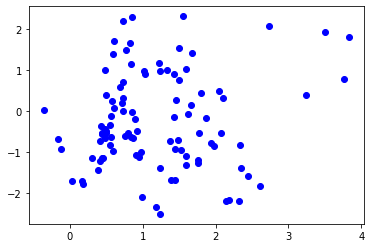

In [14]:
xs = latent_distribution[0][:100,0]
ys = latent_distribution[0][:100,1]

plt.plot(xs,ys, "ob")
plt.show()